In [1]:
import pandas as pd
from CosinorPy import file_parser, cosinor, cosinor1
import numpy as np
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

In [2]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
plt.rcParams['svg.fonttype'] = 'none'
sns.set(style='whitegrid')
np.random.seed(42)

## Setup Steps

In [3]:
#Import Phylum-level CLR, metadata, and phylum-level cosinor results
phy = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/phylum.csv', index_col = 'Unnamed: 0', low_memory = False)
data = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/metadata_all_col.csv', index_col = 'sample_id',low_memory = False)
results = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/phylum.csv', index_col = 'test')

In [4]:
#prepare input for cosinor analysis
results = results[results.q<0.05]
filt_phy = phy[results.index]
joint_file = filt_phy.join(data.col_bin).dropna()

In [5]:
# Initialize dropoff DataFrame
do_df = pd.DataFrame(0, index=range(9), columns=results.index)
do_df.iloc[0, :] = 100
do_df = do_df.reset_index().rename(columns={'index': 'Counts'})
do_df['Counts'] = [len(data), 14000, 12000, 10000, 8000, 6000, 4000, 2000, 1000]
do_df = do_df.set_index('Counts')

In [6]:
# Perform sampling and analysis
for j in range(1, len(do_df.index)):
    for i in range(100):
        samp = joint_file.sample(n=do_df.index[j])
        melted = pd.melt(samp, id_vars='col_bin').rename(columns={'col_bin': 'x', 'value': 'y', 'variable': 'test'})
        melted['x'] = melted['x'].astype(float)
        melted['y'] = melted['y'].astype(float)
        cosinor_results = cosinor1.fit_group(melted, period=[24], plot_on=False).set_index('test')
        significant_results = cosinor_results[cosinor_results.q < 0.05].index
        do_df.loc[do_df.index[j], significant_results] += 1

In [7]:
do_df.to_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/dropoff.csv')

In [8]:
phyt = phy.T
phyt['Cycling Occurrences Out of 100'] = 0
joint_all = phy.join(data.col_bin).dropna()
# Perform the sampling and analysis
for i in range(100):
    jo = joint_all.sample(n=2000)
    melted = pd.melt(jo, id_vars='col_bin').rename(columns={'col_bin': 'x', 'value': 'y', 'variable': 'test'})
    melted = melted.astype({'x': float, 'y': float})
    cosinor_results = cosinor1.fit_group(melted, period=[24], plot_on=False)
    significant_tests = cosinor_results[cosinor_results.q < 0.05]['test']
    phyt.loc[significant_tests, 'Cycling Occurrences Out of 100'] += 1

# Sort the DataFrame by 'Cycling Occurrences Out of 100'
phy_sorted = phyt.sort_values(by='Cycling Occurrences Out of 100')

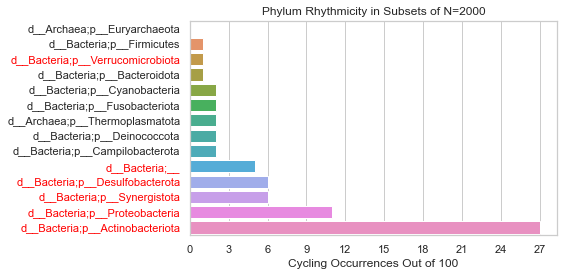

In [9]:
fig, ax = plt.subplots(figsize = (8, 4))
sns.barplot(x=phy_sorted['Cycling Occurrences Out of 100'], y=phy_sorted.index, ax=ax)
ax.set_title('Phylum Rhythmicity in Subsets of N=2000')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

# Display clades rhythmic in the whole dataset in red
for label in ax.get_yticklabels():
    if label.get_text() in phy_sorted.index and label.get_text() in results.index:
        label.set_color('red')
plt.tight_layout()
plt.savefig('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/dropoff_2000.png', dpi = 600)

In [10]:
df = pd.read_csv('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/results/dropoff.csv', index_col =0)

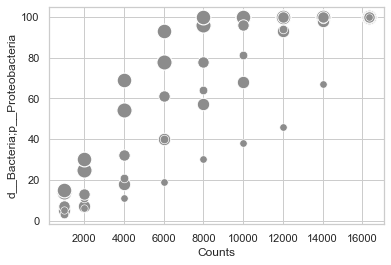

In [11]:
#This is to create the figure legend in the next figure
fig = plt.figure()
ax = fig.add_subplot()
color = sns.color_palette()[7]
scatter_proteo = sns.scatterplot(x =df.index, y =df['d__Bacteria;p__Proteobacteria'], s = results['amplitude']['d__Bacteria;p__Proteobacteria']*2000, color = color)
scatter_actino = sns.scatterplot(x =df.index, y= df['d__Bacteria;p__Actinobacteriota'], s = results['amplitude']['d__Bacteria;p__Actinobacteriota']*2000, color = color)
scatter_verruco = sns.scatterplot(x=df.index, y =df['d__Bacteria;p__Verrucomicrobiota'], s = results['amplitude']['d__Bacteria;p__Verrucomicrobiota']*2000, color = color)
scatter_synerg = sns.scatterplot(x =df.index, y =df['d__Bacteria;p__Synergistota'], s = results['amplitude']['d__Bacteria;p__Synergistota']*2000, color = color)
scatter_desulf = sns.scatterplot(x =df.index, y =df['d__Bacteria;p__Desulfobacterota'], s = results['amplitude']['d__Bacteria;p__Desulfobacterota']*2000, color = color)
scatter_unknown = sns.scatterplot(x =df.index, y =df['d__Bacteria;__'], s = results['amplitude']['d__Bacteria;__']*2000, color = color)

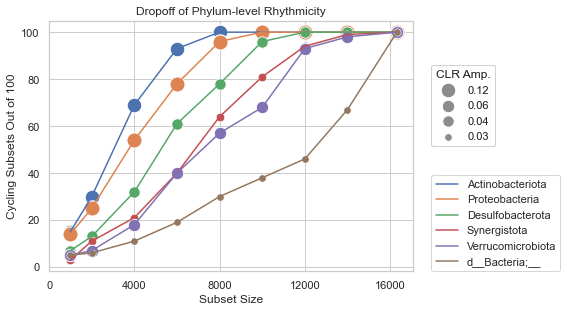

In [12]:
fig, ax = plt.subplots(figsize = (4*1.5,3*1.5))
for col in df.columns:
    color = sns.color_palette()[df.columns.get_loc(col)]
    lp = sns.lineplot(data=df, x=df.index, y=df[col], color=color)
    scatter = sns.scatterplot(x = df.index, y = df[col], s=results['amplitude'][col] * 2000, color=color)

ax.set_xlabel('Subset Size')
ax.set_ylabel('Cycling Subsets Out of 100')
ax.set_title('Dropoff of Phylum-level Rhythmicity')
plt.xticks(np.arange(0, 17000, 4000))
legend1 = plt.legend(['Actinobacteriota','Proteobacteria','Desulfobacterota','Synergistota','Verrucomicrobiota','d__Bacteria;__',], loc=(1.05,0))

legend2 = plt.legend(handles=[scatter_proteo.collections[1], scatter_desulf.collections[2],scatter_verruco.collections[4], scatter_unknown.collections[5]],
                     labels=[#str(round(results.amplitude['d__Bacteria;p__Actinobacteriota'], 2)),
                             str(round(results.amplitude['d__Bacteria;p__Proteobacteria'], 2)),
                             str(round(results.amplitude['d__Bacteria;p__Desulfobacterota'], 2)),
                             str(round(results.amplitude['d__Bacteria;p__Synergistota'], 2)),
                             #str(round(results.amplitude['d__Bacteria;p__Verrucomicrobiota'], 2)),
                             str(round(results.amplitude['d__Bacteria;__'], 2))],
                     loc=(1.05, 0.5), title='CLR Amp.')
ax.add_artist(legend2)
ax.add_artist(legend1)
plt.tight_layout()
plt.savefig('/home/shs008/zarrinpar/Pynchon/Notebooks/arrhythmia/agp/new_filtering2/figures/phylum_dropoff.png', dpi = 600)